# <center>  **<span style="font-size:80px;">Topological Features</span>** </center>

# <center> Universidad de Alicante </center>
<p align="center"><img src=".ipynb_gfx/UA.png" width="330" height="190"></p>
<br>

**Nombre:** Santiago Álvarez Geanta <br>
**Fecha:** 1 de marzo de 2025 <br>
**Grado:** Ingeniería en Inteligencia Artificial <br>
**Grupo:** 1 <br>


### Profesores
- Francisco Escolano Ruíz
- Ahmed Begga Hachlafi
<br>

In [5]:
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay 
from scipy.optimize import linear_sum_assignment

import os
import networkx as nx
from gensim.models import Word2Vec
import pandas as pd

# Ejercicio 1

## Graph Matching code

Para realizar la segunda parte del Graph Matching volveremos a utilizar las funciones implementadas anteriormente 

In [6]:
### CÁLCULOS

def load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2):
     
    img1 = Image.open(img_path1) 
    img2 = Image.open(img_path2) 
    kpts1 = np.array(sio.loadmat(mat_path1)["pts_coord"])
    kpts2 = np.array(sio.loadmat(mat_path2)["pts_coord"])
    return img1, img2, kpts1.T, kpts2.T

def delaunay_triangulation(kpt):
    tri = Delaunay(kpt)
    n = len(kpt)
    A = np.zeros((n, n), dtype=int)
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = simplex[i], simplex[j]
                A[p1, p2] = A[p2, p1] = 1
    return A

def evaluate_matching(kpts1, kpts2, matching):

    num_kpts = kpts1.shape[0]
    if num_kpts != kpts2.shape[0] or num_kpts < 0:
        return 0
    
    correct_matches = np.sum(np.diag(matching))  
    accuracy = correct_matches / num_kpts
    return accuracy


### VISUALIZACIÓN

def resize_to_same_height(img1, img2, kpts1, kpts2):
    # Obtener tamaños originales
    h1, w1 = img1.size[1], img1.size[0]
    h2, w2 = img2.size[1], img2.size[0]

    # Encontrar la altura máxima
    max_height = max(h1, h2)

    # Calcular factores de escala
    scale1 = max_height / h1
    scale2 = max_height / h2

    # Calcular nuevos anchos manteniendo la proporción
    new_w1 = int(w1 * scale1)
    new_w2 = int(w2 * scale2)

    # Redimensionar imágenes
    img1_resized = img1.resize((new_w1, max_height), Image.LANCZOS)
    img2_resized = img2.resize((new_w2, max_height), Image.LANCZOS)

    # Ajustar keypoints con los mismos factores de escala
    kpts1_resized = kpts1 * scale1
    kpts2_resized = kpts2 * scale2

    return img1_resized, img2_resized, kpts1_resized, kpts2_resized

def visualize_matching_full(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    # Asegurar que imágenes y keypoints tengan la misma escala
    img1, img2, kpts1, kpts2 = resize_to_same_height(img1, img2, kpts1, kpts2)

    img1_np = np.array(img1)
    img2_np = np.array(img2)
    
    combined_img = np.hstack((img1_np, img2_np))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(combined_img)

    row_idx, col_idx = np.where(matching)


    for i, j in zip(row_idx, col_idx):
        x1, y1 = kpts1[i]
        x2, y2 = kpts2[j] + np.array([img1_np.shape[1], 0])  # Ajustar x para la segunda imagen

        color = "green" if i == j else "red"
     
        ax.plot(x1, y1, 'ro')
        ax.plot(x2, y2, 'bo')
        ax.plot([x1, x2], [y1, y2], '-', color=color, linewidth=1.5)

    # Dibujar aristas del grafo con keypoints escalados
    draw_graph_edges(ax, kpts1, adj_matrix1, color="yellow")
    draw_graph_edges(ax, kpts2 + np.array([img1_np.shape[1], 0]), adj_matrix2, color="yellow")

    ax.axis('off')
    plt.show()

def draw_graph_edges(ax, keypoints, adj_matrix, color="yellow"):
    """Dibuja las aristas del grafo dado un conjunto de keypoints y una matriz de adyacencia."""
    num_points = keypoints.shape[0]
    for i in range(num_points):
        for j in range(i + 1, num_points):
            if adj_matrix[i, j]:  # Si hay conexión en la matriz de adyacencia
                x1, y1 = keypoints[i]
                x2, y2 = keypoints[j]
                ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=0.5)


## Graph matching with topological features

En esta última parte, utilizaremos nuevamente el Algoritmo Húngaro para encontrar el **matching óptimo**. La diferencia clave es que, en esta ocasión, emplearemos diferentes estrategias para calcular una medida de distancia entre los nodos. Los algoritmos que utilizaremos son los siguientes:

* `Node2Vec`: Un método basado en aprendizaje de representaciones (embeddings) que captura relaciones entre los nodos de un grafo mediante un enfoque de **random walks**.

* `Hitting Time`: En este caso mide el tiempo esperado para que un **random walk** en el grafo llegue desde un nodo a otro, proporcionando una noción de distancia basada en la conectividad.

* `Distancia Euclidiana`:  La medida clásica que evalúa la distancia en el espacio de keypoints.


### Node2Vec
El código para este algoritmo es bastante similar al visto durante la asignatura de Matemáticas Discretas. El objetivo será generar una representación en un espacio de dimensiones reducidas para cada nodo, para así capturar las relaciones del grafo. Utilizando **random walks** y el modelo Word2Vec obtendremos para cada nodo del grafo. 

In [7]:
def node2vec_walk(G, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        cur_node = walk[-1]
        neighbors = list(G.neighbors(cur_node))
        if len(neighbors) > 0:
            walk.append(np.random.choice(neighbors))  # Selecciona un vecino al azar
        else:
            break
    return walk


def generate_walks(G, num_walks, walk_length):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        np.random.shuffle(nodes)  
        for node in nodes:
            walks.append(node2vec_walk(G, node, walk_length))  
    return walks


def compute_node2vec_embeddings(G, dimensions=64, num_walks=10, walk_length=30):
    walks = generate_walks(G, num_walks, walk_length)  # Genera todas las caminatas aleatorias
    walks = [list(map(str, walk)) for walk in walks]  # Convierte los nodos a cadenas para gensim

    model = Word2Vec(walks, vector_size=dimensions, window=5, workers=2)  # Entrena el modelo Word2Vec con las caminatas aleatorias
    
    nodes = list(G.nodes())
    embeddings = np.zeros((len(nodes), dimensions))
    for i, node in enumerate(nodes):
        embeddings[i] = model.wv[str(node)]

    return embeddings

### Implementación Hitting Time
Recordemos que gracias al Hitting Time podemos tener una medida del tiempo que tradamops en llegar de un nodo origen a un nodo desino. Esto se debe a que nuestro algoritmo nos devuelve el número aproximado de pasos que tarda un random walk.

In [8]:
def hitting_time(G, start_node, destination_node, num_walks=100, max_steps=1000):

    hitting_times = []
    
    # Random walk
    for _ in range(num_walks):
        current = start_node
        steps = 0
        while current != destination_node and steps < max_steps:
            neighbors = list(G.neighbors(current))
            if not neighbors:
                steps = max_steps  
                break
            current = np.random.choice(neighbors)
            steps += 1
        hitting_times.append(steps)
    
    return np.mean(hitting_times)

def compute_hitting_time_matrix(G):

    n = G.number_of_nodes()
    hitting_times = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            h_time = hitting_time(G, i, j)
            hitting_times[i, j]= hitting_times[j, i] = h_time
            
    return hitting_times


### Obtención de la matriz binaria de matching
Para realizar el matching tendremos que utilizar una matriz de costes, en el que cada elemento representa una suma ponderada de varias variables. Cada una representa los algoritmos comentados anteriormente.

In [9]:
def enhanced_spatial_matching(kpts1, kpts2, adj_matrix1, adj_matrix2, weights):

    # Creación de los grafos a partir de las matrices de adyacencia
    G1 = nx.from_numpy_array(adj_matrix1)
    G2 = nx.from_numpy_array(adj_matrix2)
    
    # node2vec
    node2vec_emb1 = compute_node2vec_embeddings(G1)
    node2vec_emb2 = compute_node2vec_embeddings(G2)
    
    # hitting time
    hitting_times1 = compute_hitting_time_matrix(G1)
    hitting_times2 = compute_hitting_time_matrix(G2)

    n1 = kpts1.shape[0]
    n2 = kpts2.shape[0]
    
    cost_matrix = np.zeros((n1, n2))
    
    # Matrices de distancias (sin normalizar)
    spatial_dists = np.zeros((n1, n2))
    node2vec_dists = np.zeros((n1, n2))
    hitting_dists = np.zeros((n1, n2))
    
    
    for i in range(n1):
        for j in range(n2):
            spatial_dists[i, j] = np.linalg.norm(kpts1[i] - kpts2[j])
            node2vec_dists[i, j] = np.linalg.norm(node2vec_emb1[i] - node2vec_emb2[j])
            hitting_dists[i, j] = np.linalg.norm(hitting_times1[i] - hitting_times2[j])

    max_spatial = np.max(spatial_dists)
    max_node2vec = np.max(node2vec_dists)
    max_hitting = np.max(hitting_dists)
    
    # Evitamos la división por cero
    if max_spatial == 0: max_spatial = 1
    if max_node2vec == 0: max_node2vec = 1
    if max_hitting == 0: max_hitting = 1

    # Normalizams las distancias
    spatial_dists_normalized = spatial_dists / max_spatial
    node2vec_dists_normalized = node2vec_dists / max_node2vec
    hitting_dists_normalized = hitting_dists / max_hitting

  
    for i in range(n1):
        for j in range(n2):
            cost_matrix[i, j] = (
                weights[0] * spatial_dists_normalized[i, j] +
                weights[1] * node2vec_dists_normalized[i, j] +
                weights[2] * hitting_dists_normalized[i, j]
            )
    
    # Asignación usando el algoritmo húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Matriz de matching (binaria)
    matching = np.zeros_like(cost_matrix, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching


In [10]:
def main(filePath1, filePath2, weights, plot=False):
        
    img1, img2, kpts1, kpts2 = load_and_preprocess_images(
        img_path1= filePath1 + ".png", 
        img_path2= filePath2 + ".png",
        mat_path1= filePath1 + ".mat", 
        mat_path2= filePath2 + ".mat"
    )

    A1 = delaunay_triangulation(kpts1)
    A2 = delaunay_triangulation(kpts2)
    
    matching = enhanced_spatial_matching(kpts1, kpts2, A1, A2, weights)
    
    if plot:
        plt.figure(figsize=(16, 7))
        visualize_matching_full(img1, img2, kpts1, kpts2, A1, A2, matching)
    
    return kpts1, kpts2, matching

# Ejercicio 2
Visualize the optimal assignment by connecting the matched keypoints with lines on the images.

<Figure size 1600x700 with 0 Axes>

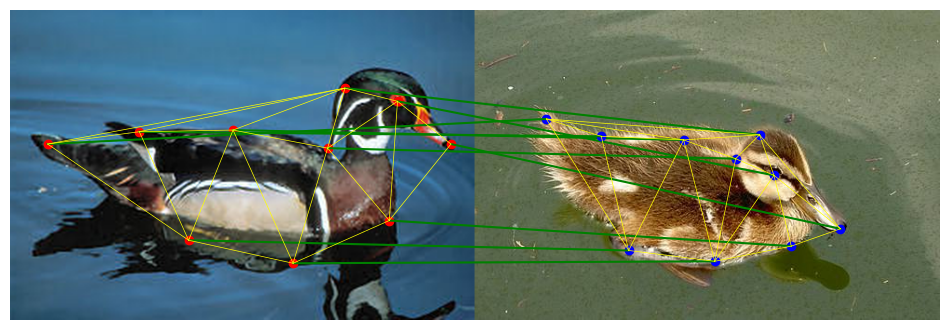

(array([[284.18700265,  86.17639257],
        [249.70424403,  58.59018568],
        [215.75198939,  50.10212202],
        [204.61140584,  88.82891247],
        [244.39920424, 135.5132626 ],
        [143.60344828,  77.15782493],
        [ 83.12599469,  78.21883289],
        [ 23.93985176,  86.17664337],
        [114.95623342, 148.24535809],
        [182.33023873, 163.0994695 ]]),
 array([[392.54895105, 234.53146853],
        [321.13636364, 177.09090909],
        [305.61188811, 133.62237762],
        [279.9965035 , 159.23776224],
        [339.76573427, 253.16083916],
        [224.10839161, 139.05594406],
        [135.61888112, 135.17482517],
        [ 76.62587413, 116.54545455],
        [165.11538462, 257.81818182],
        [257.48601399, 269.46153846]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [11]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/"

# Ejemplo de ejecución:
filePath1 = "Duck/060_0081"  
filePath2 = "Duck/060_0066" 
main(dataPath+filePath1, dataPath+filePath2, weights=(0.4, 0.3, 0.3), plot=True)

# Ejercicio 3

Evaluate the accuracy for each category, and create a csv file with the results of each category, reporting the mean accuracy for each category and the standard deviation.

In [12]:
def writeCSV(results, output_csv="results2.csv"):
    try:
        df = pd.DataFrame([results], columns=["Category", "Mean Accuracy", "Std_Deviation", "Number_of_Images"])
        

        if os.path.exists(output_csv):
            df.to_csv(output_csv, mode='a', header=False, index=False)
        else:
            df.to_csv(output_csv, mode='w', header=True, index=False)
        
        print(f"Resultados guardados en {output_csv}")
    except Exception as e:
        print(f"Error al guardar el archivo CSV: {e}")

In [14]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/"
categories = ["Duck", "Car", "Face", "Motorbike", "Winebottle"]

for category in categories:
    num_images = 1
    accuracies = list()
    files = os.listdir(dataPath + category + "/")
    files = [os.path.splitext(file)[0] for file in files if file.endswith('.png')]

    for i in range(1, 13):
        num_images += 1
        kpts1, kpts2, matching = main(filePath1= dataPath+category+"/"+files[0], filePath2= dataPath+category+"/"+files[i], weights=(0.4, 0.3, 0.3))
        accuracies.append(evaluate_matching(kpts1= kpts1, kpts2= kpts2, matching= matching))

    writeCSV(results=[f"{category}", np.mean(accuracies), np.std(accuracies), f"{num_images}"])
    

Resultados guardados en results2.csv
Resultados guardados en results2.csv
Resultados guardados en results2.csv
Resultados guardados en results2.csv
Resultados guardados en results2.csv


## Extra
En este ejercicio se nos ofrece lo siguiente: "If you need to perform any other experiment, this is the time to do it". Me puse a pensar y he decidio aplicar **Dijkstra** para para definir una métrica de distancia entre keypoints en el grafo. Además, aprovecharemos que estamos tratando con grafos de tamaño reducido para aplicar el algoritmo.

In [ ]:
def compute_shortest_path_matrix(G):
    
    n = len(G.nodes)
    shortest_paths = np.full((n, n), np.inf) # Marcamos todos los nodos como no visitados
    
    for i in range(n):
        lengths = nx.single_source_dijkstra_path_length(G, i)
        for j in lengths:
            shortest_paths[i, j] = lengths[j]
    
    return shortest_paths

def shortest_path_matching(kpts1, kpts2, adj_matrix1, adj_matrix2):
    G1 = nx.from_numpy_array(adj_matrix1)
    G2 = nx.from_numpy_array(adj_matrix2)
        
    cost_matrix = compute_shortest_path_matrix(G1) + compute_shortest_path_matrix(G2)
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching


In [ ]:
def main2(filePath1, filePath2, plot=False):
          
    img1, img2, kpts1, kpts2 = load_and_preprocess_images(
        img_path1= filePath1 + ".png", 
        img_path2= filePath2 + ".png",
        mat_path1= filePath1 + ".mat", 
        mat_path2= filePath2 + ".mat"
    )

    A1 = delaunay_triangulation(kpts1)
    A2 = delaunay_triangulation(kpts2)
    
    matching = shortest_path_matching(kpts1, kpts2, A1, A2)
    
    if plot:
        plt.figure(figsize=(16, 7))
        visualize_matching_full(img1, img2, kpts1, kpts2, A1, A2, matching)
    
    return kpts1, kpts2, matching

<Figure size 1600x700 with 0 Axes>

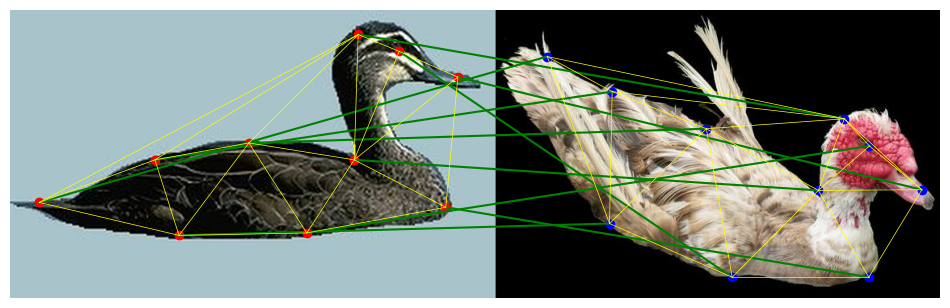

(array([[265.24791086,  39.79665738],
        [230.47632312,  24.55431755],
        [206.18384401,  14.55153203],
        [203.80222841,  88.85793872],
        [258.10306407, 116.96100279],
        [141.40389972,  78.8551532 ],
        [ 85.67409471,  88.85793872],
        [ 17.08356546, 114.10306407],
        [ 99.9637883 , 133.63231198],
        [175.69916435, 132.20334262]]),
 array([[527.04137931, 222.49655172],
        [292.32413793, 330.82758621],
        [431.02068966, 134.68275862],
        [399.0137931 , 223.31724138],
        [461.3862069 , 330.82758621],
        [260.31724138, 146.99310345],
        [143.77931034, 101.03448276],
        [ 63.34156036,  57.65497971],
        [140.49655172, 264.35172414],
        [462.20689655, 168.33103448]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [ ]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/"

# Ejemplo de ejecución:
filePath1 = "Duck/060_0000"  
filePath2 = "Duck/060_0003" 
main2(dataPath+filePath1, dataPath+filePath2, plot=True)

El resultado obtenido es el esperado, ya que Dijkstra encuentra de manera eficiente las distancias más cortas entre nodos, lo que garantiza un matching preciso. Al tratarse de un algoritmo que minimiza las distancias, asegura que cada punto se empareje con su mejor coincidencia, evitando asignaciones incorrectas.

In [ ]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/Car/"

accuracies = list()
files = os.listdir(dataPath)
files = [os.path.splitext(file)[0] for file in files if file.endswith('.png')]
data_weight = [[0.3, 0.4, 0.5, 0.6], [0.2, 0.3, 0.4], [0.2, 0.3, 0.4]]
weight = [None] * len(data_weight)

for indx, values in enumerate(data_weight):
    for value in values:
        
        weight[:] = [(1-value)/2] * len(weight)
        weight[indx] = value

        for i in range(1, 12):
            kpts1, kpts2, matching = main(filePath1= dataPath+files[0], filePath2= dataPath+files[i], weights=weight)
            accuracies.append(evaluate_matching(kpts1= kpts1, kpts2= kpts2, matching= matching))
        
        results = [weight, str(np.mean(accuracies)), str(np.std(accuracies))]
        df = pd.DataFrame([results], columns=["weight", "Mean Accuracy", "Std Deviation"])
        
        if os.path.exists("weights.csv"):
            df.to_csv("weights.csv", mode='a', header=False, index=False)
        else:
            df.to_csv("weights.csv", mode='w', header=True, index=False)
        
        accuracies = list()


## Report

In [16]:
import numpy as np

def knn_triangulation(kpts, k):
    npuntos = kpts.shape[0]
    A = np.zeros((npuntos, npuntos), dtype=int)
    D = np.zeros((npuntos, npuntos))

    # Calculamos las distancias entre todos los puntos
    for i in range(npuntos):
        for j in range(i + 1, npuntos):
            p1 = kpts[i]
            p2 = kpts[j]
            D[i, j] = D[j, i] = np.linalg.norm(p2 - p1)  # Euclidean distance

    # Ordenamos las distancias y obtenemos los k vecinos más cercanos para cada punto
    neighbors = np.argsort(D, axis=1)[:, 1:k + 1]  # Ignoramos el punto mismo (la primera columna)

    for i in range(npuntos):
        for j in neighbors[i]:
            A[i, j] = A[j, i] = 1  

    return A


In [15]:
def main3(filePath1, filePath2, weights, k, plot=False):
        
    img1, img2, kpts1, kpts2 = load_and_preprocess_images(
        img_path1= filePath1 + ".png", 
        img_path2= filePath2 + ".png",
        mat_path1= filePath1 + ".mat", 
        mat_path2= filePath2 + ".mat"
    )

    A1 = knn_triangulation(kpts1, k)
    A2 = knn_triangulation(kpts2, k)
    
    matching = enhanced_spatial_matching(kpts1, kpts2, A1, A2, weights)
    
    if plot:
        plt.figure(figsize=(16, 7))
        visualize_matching_full(img1, img2, kpts1, kpts2, A1, A2, matching)
    
    return kpts1, kpts2, matching

<Figure size 1600x700 with 0 Axes>

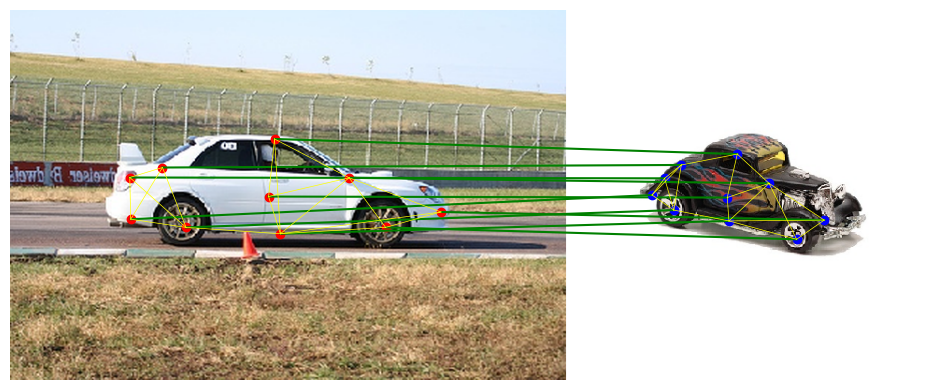

<Figure size 1600x700 with 0 Axes>

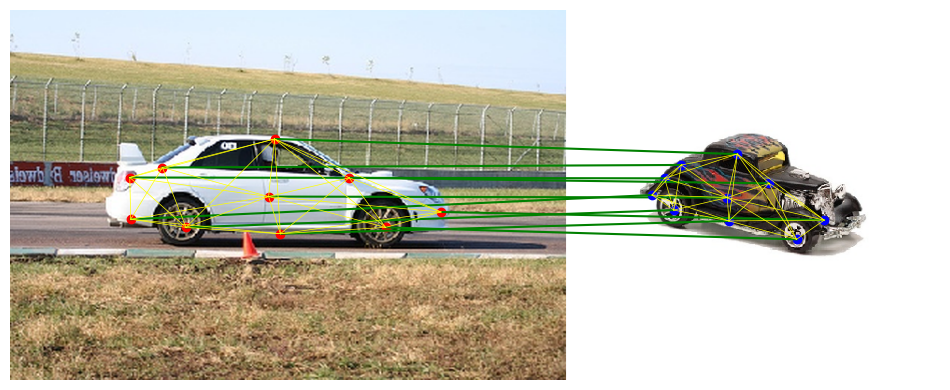

<Figure size 1600x700 with 0 Axes>

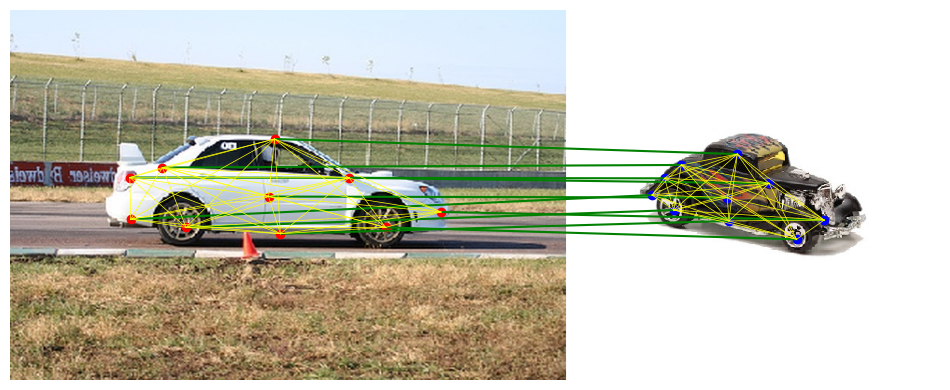

<Figure size 1600x700 with 0 Axes>

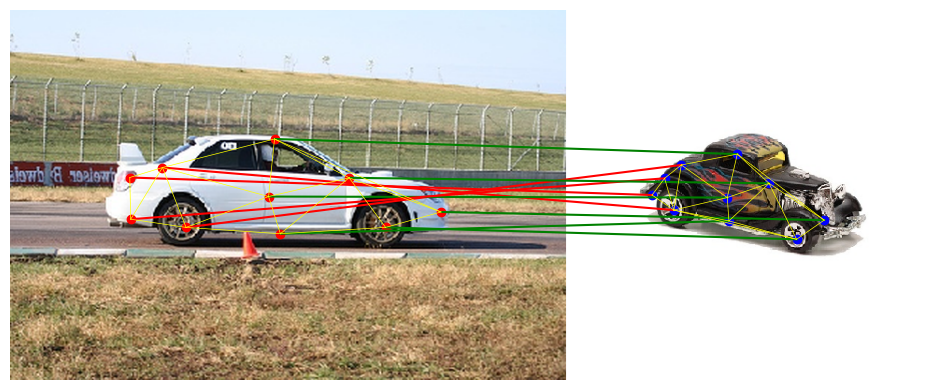

In [20]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/Car/"

accuracies = list()
files = os.listdir(dataPath)
files = [os.path.splitext(file)[0] for file in files if file.endswith('.png')]

### Resultado knn
for k in [3, 5, 7]:
    for i in range(1, 12):
        plot = False if i > 1 else True
        kpts1, kpts2, matching = main3(filePath1= dataPath+files[0], filePath2= dataPath+files[i], weights=(0.4, 0.3, 0.3), k=k, plot=plot)
        accuracies.append(evaluate_matching(kpts1= kpts1, kpts2= kpts2, matching= matching))

    results = [k, str(np.mean(accuracies)), str(np.std(accuracies))]
    df = pd.DataFrame([results], columns=["K", "Mean Accuracy", "Std Deviation"])

    if os.path.exists("results3.csv"):
        df.to_csv("results3.csv", mode='a', header=False, index=False)
    else:
        df.to_csv("results3.csv", mode='w', header=True, index=False)
    
    accuracies = list()


### Resultado delaunay

for i in range(1, 12):
    plot = False if i > 1 else True
    kpts1, kpts2, matching = main(filePath1= dataPath+files[0], filePath2= dataPath+files[i], weights=(0.4, 0.3, 0.3), plot=plot)
    accuracies.append(evaluate_matching(kpts1= kpts1, kpts2= kpts2, matching= matching))

results = [None, str(np.mean(accuracies)), str(np.std(accuracies))]
df = pd.DataFrame([results], columns=["K", "Mean Accuracy", "Std Deviation"])

if os.path.exists("results3.csv"):
    df.to_csv("results3.csv", mode='a', header=False, index=False)
else:
    df.to_csv("results3.csv", mode='w', header=True, index=False)


### <center>Santiago Álvarez Geanta</center>
#### <center>Universidad de Alicante</center>
<p align="center"><img src=".ipynb_gfx/UA.png" width="165" height="95"></p>